# House Price Prediction with proper visualization and comments. 🔥🔥🔥

### The purpose of this notebook is to understand the lifecycle of a ML project in a clear & easy way.
### For each step, I will be writing down why it's done in the beginning and what's the conclusion we had after the execution.


In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/sample_submission.csv


In [99]:
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

### First, we will concat both the datasets so that whatever transformation we make, we don't have to do it two times for each.
### We will be adding an extra column for identifying which one is the test data and which is train data. In the end, right before feeding the data to our model we will split the dataset again into train and test.


In [100]:
# If the value in the 'train_test' column is 1 then it is training data otherwise it is test data.
train['train_test'] = 1 
test['train_test'] = 0
test['SalePrice'] = np.NaN

all_data = pd.concat([train, test]) # This will be our complete dataset (test + train)

In [101]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

## Data Cleaning / Taking care of null values.

##### We can see that there are some columns which have plenty of null values. It's ideal to remove such columns when the missing data is more than 50% of the total size.

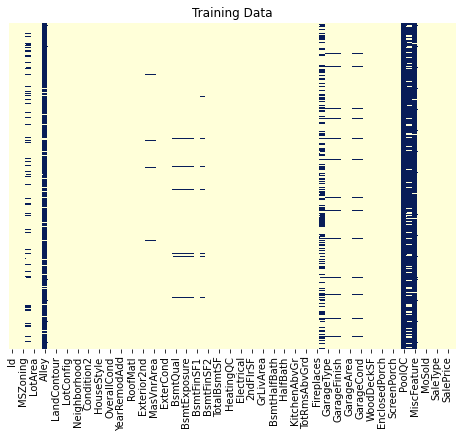

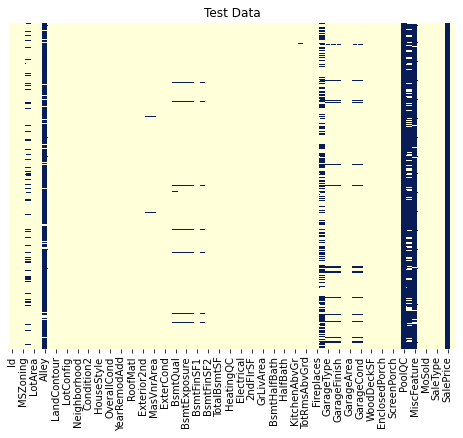

In [102]:
# Let's try to plot the null values for a better intution about which column has how many null values.

import seaborn as sns
import matplotlib.pyplot as plt

# Let's look at training and test data seperately.

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(all_data[all_data['train_test'] == 1].isnull(), cmap="YlGnBu", cbar = False, yticklabels=False).set_title('Training Data')

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_data[all_data['train_test'] == 0].isnull(), cmap="YlGnBu", cbar = False, yticklabels=False).set_title('Test Data')

plt.show()

##### The density against the column names shows how many null values are present in them.
##### We can see that there are a lot of null values in the following columns in both train and test data: 'PoolQC', 'Alley', 'MiscFeature'

In [103]:
# Dropping the columns that we decided
all_data.drop(columns = ['PoolQC', 'Alley', 'MiscFeature'], inplace = True)

In [104]:
# FireplaceQu looks confusing, let's see the percentage of null values in that column.

(all_data['FireplaceQu'].isnull().sum() / all_data['FireplaceQu'].size) * 100

48.646796848235695

##### Less than 50% so it's okay, we will not drop this column.

In [105]:
# Let's crosscheck the null value situation now

for i in range(len(train.isnull().sum())):
    if(train.isnull().sum()[i] > 0):
        print(train.columns[i] + " " + str(train.isnull().sum()[i]))

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


##### Note that SalePrice is null because the test data is also added in this 'all_data', and all other columns that have null values will be dealt with.


### Let's have a look at the correlation, it will help us understand which column are important and which are not.

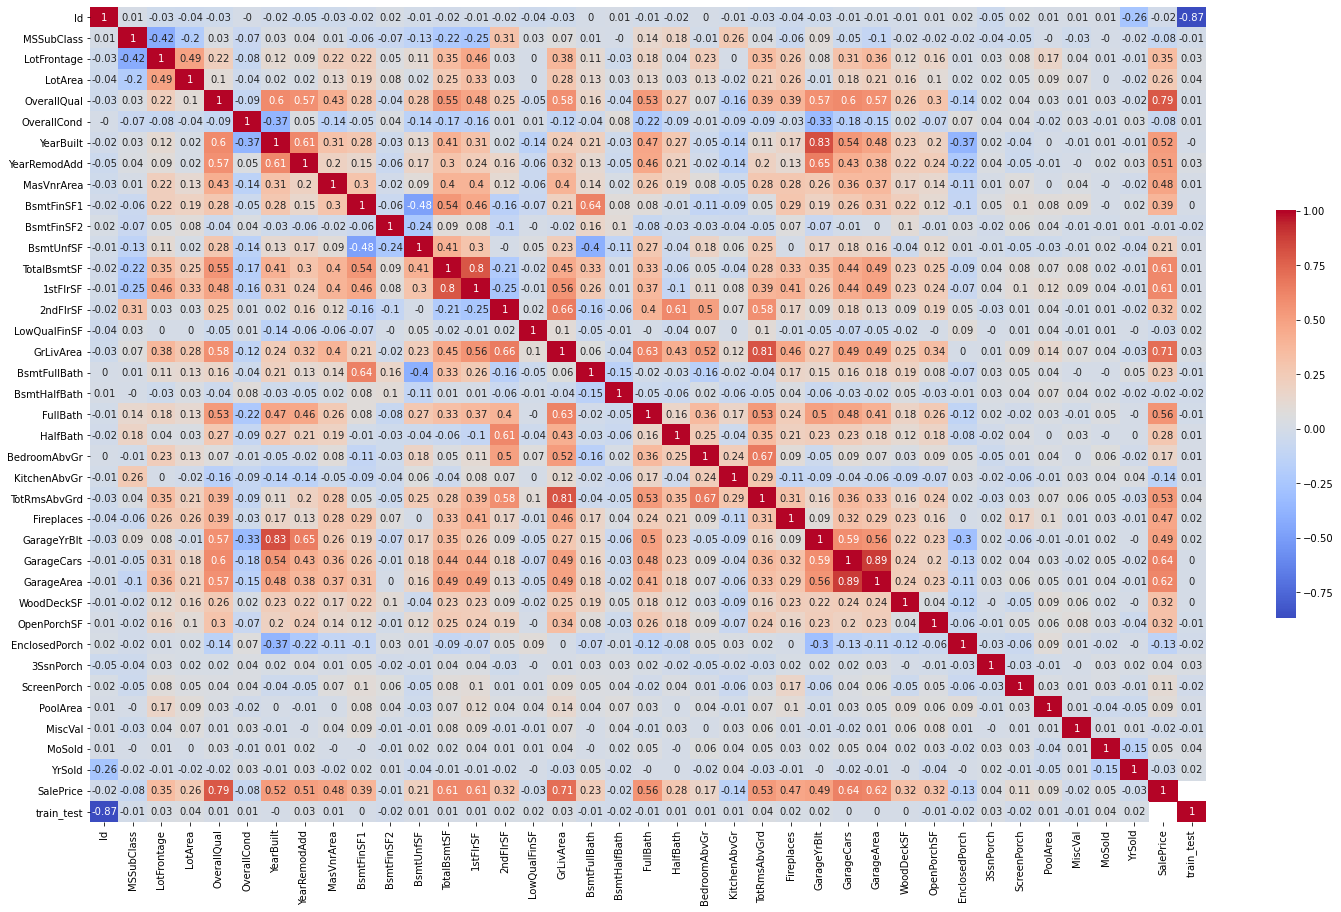

In [106]:
plt.figure(figsize = (25, 15))
mask = np.triu(np.ones_like(all_data.corr(), dtype=bool))
sns.heatmap(all_data.corr().round(2), cmap='coolwarm', annot=True,cbar_kws={"shrink": .5})

We can conclude at this point that some imporatant features are:
1. LotFrontAge 0.35
1. OverallQual 0.79
1. YearBuilt 0.52
1. YearRemodAdd 0.51
1. MasVnrArea 0.48
1. BsmtFrinSF1 0.39
1. TotalBsmtSF 0.61
1. 1stFlrSF 0.61
1. GRLivArea 0.71
1. Fullbath 0.56
1. TotRmsAbvGrd 0.53
1. Fieplaces 0.47
1. GarageYrBlt 0.49
1. GarageCars 0.64
1. GarageArea 0.62*

### Now we will take columns one by one, see how important they are by finding correlation and deal with them.

#### Fence


In [107]:
# Fence has a lot of null values, let's see what we can do with this.
print("The unique values in Fence are: " + str(all_data['Fence'].unique() )) # This gives us all the types of Fence that are there for the houses, We will try to make it like either yes or no. (A house has fence or not.)

The unique values in Fence are: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


In [108]:
# Insert 1 in Fence column if there is any kind of fence available, else put 0.
all_data['Fence'] = np.where(all_data['Fence'].isnull(), 0,1)

#### GarageCond

The unique values in GarageCond are: ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']


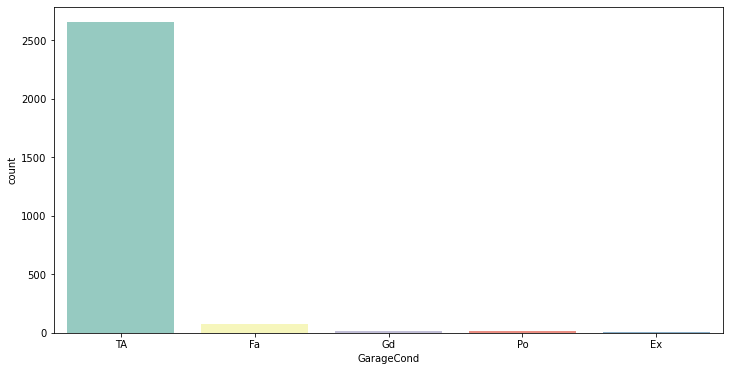

In [109]:
# Now we will take care of the GarageCond column
print("The unique values in GarageCond are: " + str(all_data['GarageCond'].unique()))

# Let's visualize the distribution of values in this column:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'GarageCond', data = all_data, palette="Set3")

##### Looks like majority of rows have 'TA' as value in GarageCond column. It's ideal to fill the null cells with this value.

In [110]:
all_data['GarageCond'].fillna('TA', inplace = True)

#### LotFrontage

In [111]:
print("These are the unique values in the LotFrontage column: " + str(all_data['LotFrontage'].unique()))

These are the unique values in the LotFrontage column: [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.  26.
  25. 119.  31.  28. 117. 113. 125. 135. 136.  22. 123. 195. 155. 126.
 200. 131. 133.]


##### Let's find out the Kernel density of this column to see the distribution of values.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:335: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


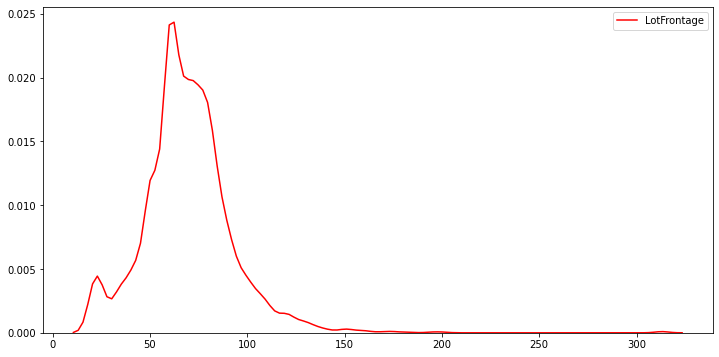

In [112]:
plt.figure(figsize = (12, 6))
sns.kdeplot(all_data['LotFrontage'], c = 'r')

##### Note that the distribution is not bell shaped, so it's a good idea to take log of this column.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:335: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


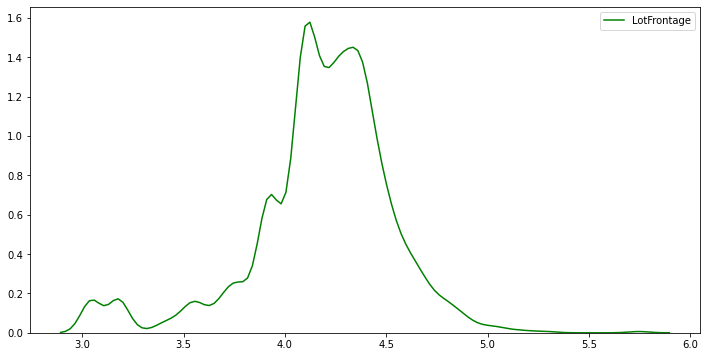

In [113]:
all_data['LotFrontage'] = np.log(all_data['LotFrontage']) # This line will convert the values in the column to their log.

plt.figure(figsize = (12, 6))
sns.kdeplot(all_data['LotFrontage'], c = 'g') # This should give us a normally distributed kde plot.

In [114]:
# Since we have a normally distributed plot, it's ideal to fill the missing values with the mean.

all_data['LotFrontage'].fillna(all_data['LotFrontage'].mean(), inplace = True)

#### FireplaceQu

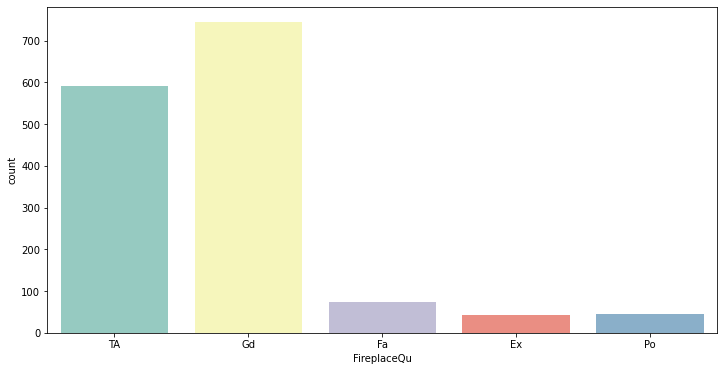

In [115]:
# Let's us start by plotting the categorical values in this column:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'FireplaceQu', data = all_data, palette="Set3") 

# For the reference, the abbrevations in this column stands for:
#        Ex	Excellent - Exceptional Masonry Fireplace
#        Gd	Good - Masonry Fireplace in main level
#        TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#        Fa	Fair - Prefabricated Fireplace in basement
#        Po	Poor - Ben Franklin Stove
#        NA	No Fireplace

##### The values of TA and Gd are both pretty high, we can't fill the null values randomly. Let's try to find the correlation of this column and see if it's really important to keep this one.
##### Filling the values randomly can drastically effect the results.
##### We can make one assumption that the cells that have nan actually mean NA (No fireplace), since it is there is the column description but not present in the actual data. We will go with dropping this column as it's quite unpredictible and not clear.

In [116]:
all_data['FireplaceQu'].unique()
all_data.drop(columns = 'FireplaceQu', inplace = True)

#### GarageYrBlt 
##### Positive correlation with SalePrice (+0.49)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:335: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


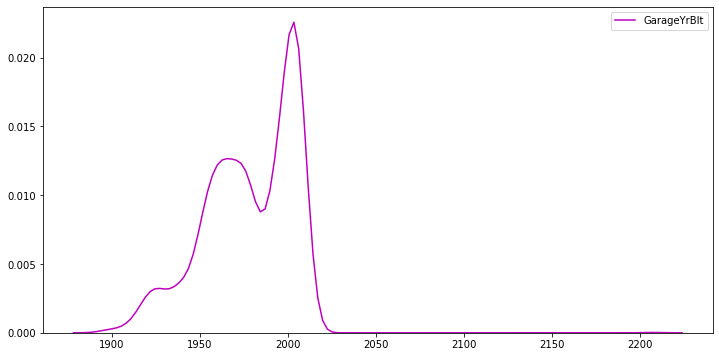

In [117]:
# Let's try to plot a kde for this column:

plt.figure(figsize = (12, 6))
sns.kdeplot(all_data['GarageYrBlt'], c = 'm')

##### By analysing for a while, I realised that there's year 2207 in the test data which was causing heavy tailed distribution for our all_data.
##### Let's try to plot the same kde just for the Train data:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:335: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


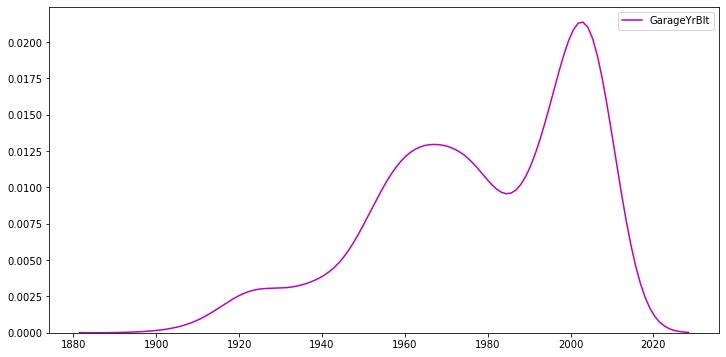

In [118]:
plt.figure(figsize = (12, 6))
sns.kdeplot(all_data[all_data['train_test'] == 1]['GarageYrBlt'], c = 'm')

##### We can see that the plot above is more evenly distributed. We can take the mean of this data and fill the null values.

In [119]:
all_data['GarageYrBlt'].fillna(all_data[all_data['train_test'] == 1]['GarageYrBlt'].mean(), inplace = True)

#### TotalBsmtSF

Number of null values in TotalBsmtSF: 1


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:335: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


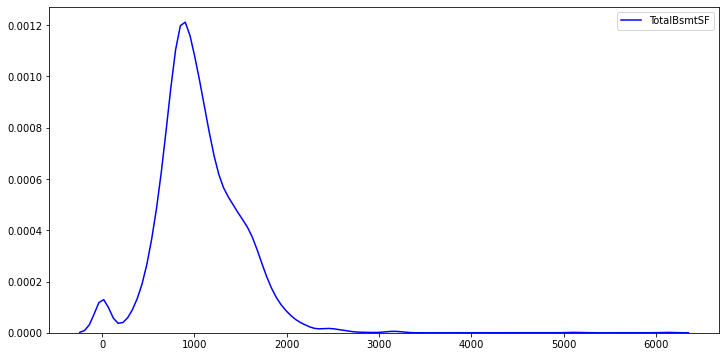

In [120]:
print('Number of null values in TotalBsmtSF: ' + str(all_data['TotalBsmtSF'].isnull().sum()))

plt.figure(figsize = (12, 6))
sns.kdeplot(all_data['TotalBsmtSF'], c = 'b')

##### The plot is not nicely distributed, we will choose the mean to fill the null value.

In [121]:
all_data['TotalBsmtSF'].fillna(all_data['TotalBsmtSF'].median(), inplace = True)

#### BsmtFrinSF1

In [122]:
all_data['BsmtFinSF1'].isnull().sum() # shows that there is only 1 null value.

1

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:335: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


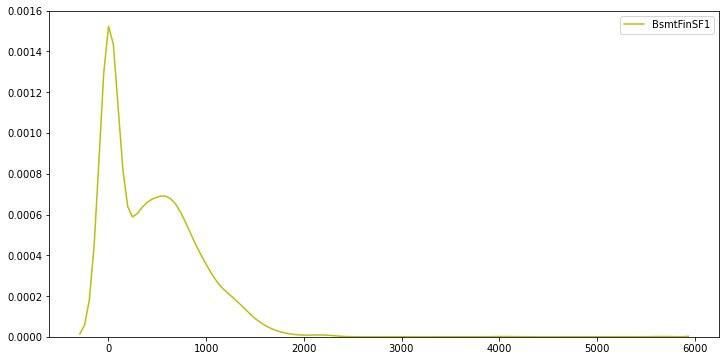

In [123]:
plt.figure(figsize = (12, 6))
sns.kdeplot(all_data['BsmtFinSF1'], c = 'y')

##### The plot tells us that the highest value is too far away from the mean value. So it's not a good idea to fill the null value with the mean, instead we will fill it up with the median.

In [124]:
all_data['BsmtFinSF1'].fillna(all_data['BsmtFinSF1'].mean(), inplace = True)

#### GarageCars

In [125]:
all_data['GarageCars'].isnull().sum()

1

##### Has only one missing value.

In [126]:
all_data['GarageCars'].unique()

# Note that the GarageCars represents the number of cars the Garage can hold. This should not be a decimal value, so we can't really use the mean.
# Let's fill it up with the median.

array([ 2.,  3.,  1.,  0.,  4.,  5., nan])

In [127]:
all_data['GarageCars'].fillna(all_data['GarageCars'].median(), inplace = True)

#### GarageArea

In [130]:
all_data['GarageArea'].isnull().sum()

1

##### Has only one missing value.

In [132]:
all_data['GarageArea'].unique() #Shows a lot of values, which might look ambiguous... Let's try to plot this.

array([ 548.,  460.,  608.,  642.,  836.,  480.,  636.,  484.,  468.,
        205.,  384.,  736.,  352.,  840.,  576.,  516.,  294.,  853.,
        280.,  534.,  572.,  270.,  890.,  772.,  319.,  240.,  250.,
        271.,  447.,  556.,  691.,  672.,  498.,  246.,    0.,  440.,
        308.,  504.,  300.,  670.,  826.,  386.,  388.,  528.,  894.,
        565.,  641.,  288.,  645.,  852.,  558.,  220.,  667.,  360.,
        427.,  490.,  379.,  297.,  283.,  509.,  405.,  758.,  461.,
        400.,  462.,  420.,  432.,  506.,  684.,  472.,  366.,  476.,
        410.,  740.,  648.,  273.,  546.,  325.,  792.,  450.,  180.,
        430.,  594.,  390.,  540.,  264.,  530.,  435.,  453.,  750.,
        487.,  624.,  471.,  318.,  766.,  660.,  470.,  720.,  577.,
        380.,  434.,  866.,  495.,  564.,  312.,  625.,  680.,  678.,
        726.,  532.,  216.,  303.,  789.,  511.,  616.,  521.,  451.,
       1166.,  252.,  497.,  682.,  666.,  786.,  795.,  856.,  473.,
        398.,  500.,

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:335: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


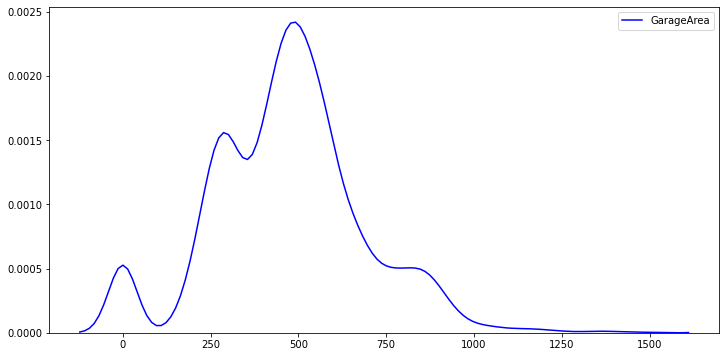

In [133]:
plt.figure(figsize = (12, 6))
sns.kdeplot(all_data['GarageArea'], c = 'b')

##### Plot shows that it is nicely distributed, we can go for the mean.

In [137]:
all_data['GarageArea'].fillna(all_data['GarageArea'].mean(), inplace = True)

In [138]:
for i in range(len(all_data.isnull().sum())):
    if(all_data.isnull().sum()[i] > 0):
        print(all_data.columns[i] + " " + str(all_data.isnull().sum()[i]))
        
        

MSZoning 4
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 24
MasVnrArea 23
BsmtQual 81
BsmtCond 82
BsmtExposure 82
BsmtFinType1 79
BsmtFinType2 80
BsmtFinSF2 1
BsmtUnfSF 1
Electrical 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
GarageType 157
GarageFinish 159
GarageQual 159
SaleType 1
SalePrice 1459


# In-progress